In [13]:
import nltk
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')
df = pd.read_csv('data/IMDB Dataset.csv')
# Set of English stop words
stop_words = set(stopwords.words('english'))

# Function to clean text data
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\'", " ", text)  # Remove apostrophes
    text = re.sub(r"[^\w\s]", " ", text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = ' '.join([w for w in text.split() if len(w) > 2])  # Remove short words
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    return text

# Assuming df is your DataFrame containing reviews and sentiment labels
df["review"] = df["review"].astype(str)
df["review"] = df["review"].apply(clean_text)

# Tokenize the reviews
tokenized_reviews = df["review"].apply(nltk.word_tokenize)
df["tokenized_reviews"] = tokenized_reviews

# Tokenizer and sequence padding
tokenizer = Tokenizer(num_words=5000)  # Limit the vocabulary size
tokenizer.fit_on_texts(tokenized_reviews)
sequences = tokenizer.texts_to_sequences(tokenized_reviews)
X = pad_sequences(sequences, maxlen=500)

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["sentiment"])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

# Early stopping and learning rate decay
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-5)

# Build LSTM model
vocab_size = min(tokenizer.num_words, len(tokenizer.word_index)) + 1  # Use num_words from tokenizer
print(vocab_size)

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=500),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, reduce_lr])





[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camille/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/camille/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


5001


"model_lstm = Sequential([\n    Embedding(input_dim=vocab_size, output_dim=128, input_length=500),\n    LSTM(128, return_sequences=True),\n    Dropout(0.2),\n    LSTM(64),\n    Dropout(0.2),\n    Dense(1, activation='sigmoid')\n])\n\nmodel_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n\n# Fit the model\nmodel_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, reduce_lr])\n\n\nmodel_lstm = Sequential([\n    Embedding(input_dim=vocab_size, output_dim=128, input_length=500),\n    LSTM(128, return_sequences=True),\n    Dropout(0.2),\n    LSTM(64),\n    Dropout(0.2),\n    Dense(1, activation='sigmoid')\n])\n\nmodel_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])\n\n# Fit the model\nmodel_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, reduce_lr])"

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


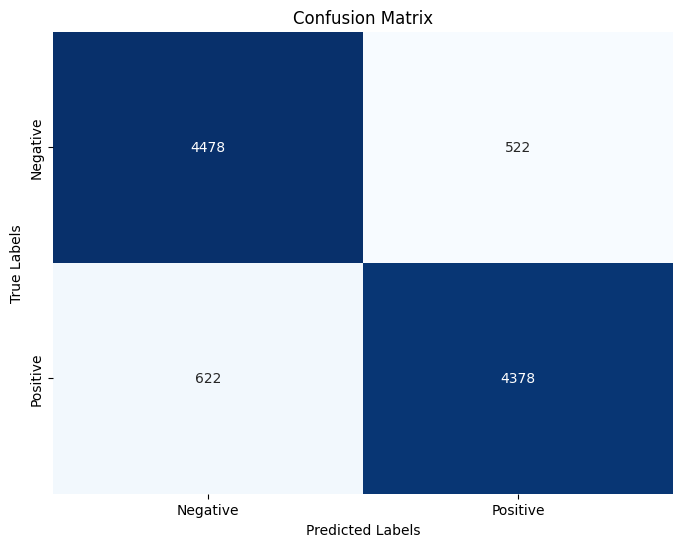

In [10]:
# Generate predictions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_prob = model_lstm.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.8856
Precision: 0.8934693877551021
Recall: 0.8756
F1-score: 0.8844444444444445
Sensitivity: 0.49
Specificity: 0.51


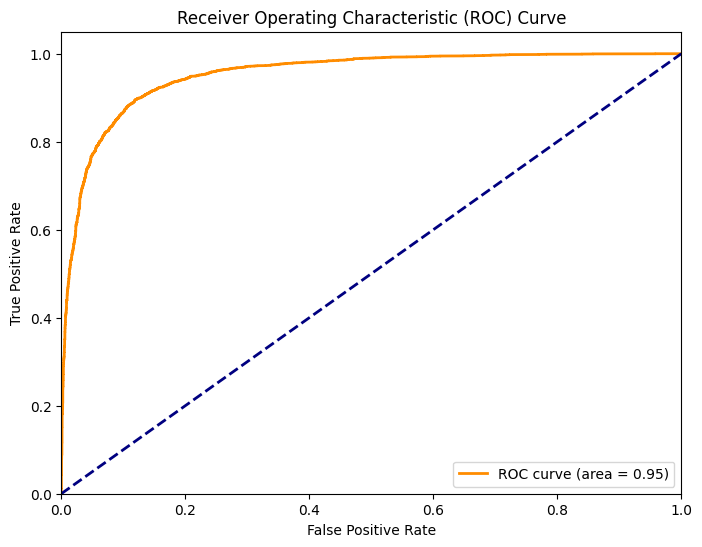

AUC: 0.9520153600000001


In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Precision
precision = precision_score(y_test, y_pred_classes)

# Recall
recall = recall_score(y_test, y_pred_classes)

# F1-score
f1 = f1_score(y_test, y_pred_classes)

# True Positives, True Negatives, False Positives, False Negatives
tp = np.sum((y_test == 1) & (y_pred_classes == 1))
tn = np.sum((y_test == 0) & (y_pred_classes == 0))
fp = np.sum((y_test == 0) & (y_pred_classes == 1))
fn = np.sum((y_test == 1) & (y_pred_classes == 0))

# Sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Print performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


### With others parameters

Gives bad results 

```python
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=500),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, reduce_lr]
```

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Define your model
model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128, input_length=500),
    LSTM(128),
    Dropout(0.2),
    Dense(64, activation='relu'),  # Additional dense layer after LSTM
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Fit the model
model_lstm.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32, callbacks=[early_stopping, reduce_lr])


Epoch 1/10


/Users/camille/miniconda3/envs/keras-jax/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 146s 116ms/step - accuracy: 0.7787 - loss: 0.4431 - val_accuracy: 0.8820 - val_loss: 0.2896 - learning_rate: 0.0010
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 125s 100ms/step - accuracy: 0.8993 - loss: 0.2532 - val_accuracy: 0.8907 - val_loss: 0.2806 - learning_rate: 0.0010
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 121s 97ms/step - accuracy: 0.9240 - loss: 0.1948 - val_accuracy: 0.8835 - val_loss: 0.2905 - learning_rate: 0.0010
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 122s 98ms/step - accuracy: 0.9408 - loss: 0.1560 - val_accuracy: 0.8660 - val_loss: 0.3245 - learning_rate: 0.0010
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 121s 97ms/step - accuracy: 0.9666 - loss: 0.0971 - val_accuracy: 0.8799 - val_loss: 0.4132 - learning_rate: 2.0000e-04


313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


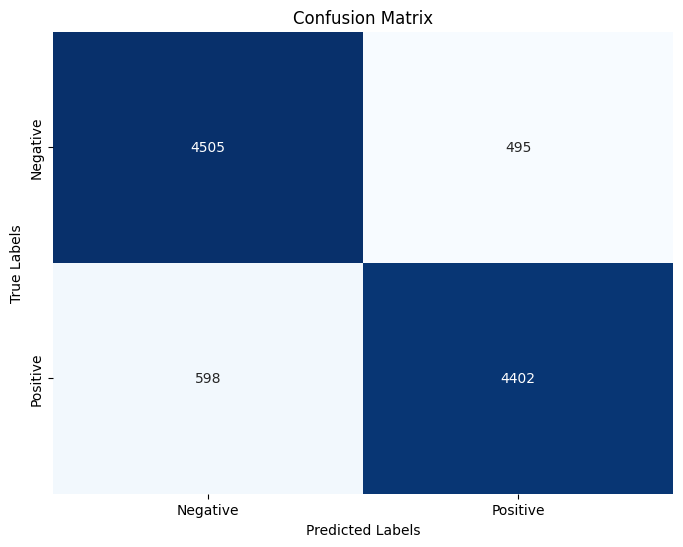

Accuracy: 0.8907
Precision: 0.8989177047171738
Recall: 0.8804
F1-score: 0.889562493684955
Sensitivity: 0.4897
Specificity: 0.5103


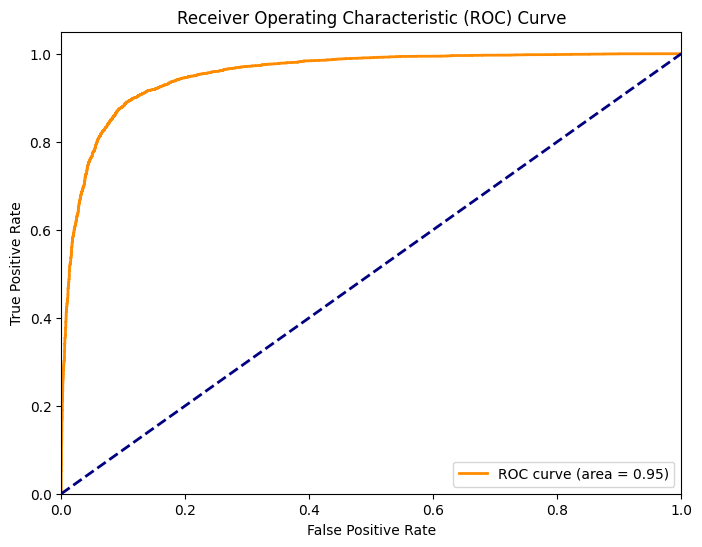

AUC: 0.95378932


In [16]:
# Generate predictions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred_prob = model_lstm.predict(X_test)
y_pred_classes = (y_pred_prob > 0.5).astype("int32")

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)

# Precision
precision = precision_score(y_test, y_pred_classes)

# Recall
recall = recall_score(y_test, y_pred_classes)

# F1-score
f1 = f1_score(y_test, y_pred_classes)

# True Positives, True Negatives, False Positives, False Negatives
tp = np.sum((y_test == 1) & (y_pred_classes == 1))
tn = np.sum((y_test == 0) & (y_pred_classes == 0))
fp = np.sum((y_test == 0) & (y_pred_classes == 1))
fn = np.sum((y_test == 1) & (y_pred_classes == 0))

# Sensitivity (True Positive Rate)
sensitivity = tp / (tp + fn)

# Specificity (True Negative Rate)
specificity = tn / (tn + fp)

# Print performance metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("Sensitivity:", sensitivity)
print("Specificity:", specificity)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)


# Ask me 


In [51]:
def preprocess_sentence(sentence):
    # Clean the input sentence
    cleaned_sentence = clean_text(sentence)
    # Tokenize the sentence
    tokenized_sentence = nltk.word_tokenize(cleaned_sentence)
    # Convert tokens to sequences
    sequence = tokenizer.texts_to_sequences([tokenized_sentence])
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=500)
    return padded_sequence

def predict_sentiment(model, sentence):
    # Preprocess the input sentence
    preprocessed_sentence = preprocess_sentence(sentence)
    # Make prediction
    prediction = model.predict(preprocessed_sentence)
    # Convert prediction to class
    predicted_class = "Positive" if prediction > 0.5 else "Negative"
    return predicted_class

# Example usage:
sentence = "Very bad movie! Waste of time."
predicted_class = predict_sentiment(model_lstm, sentence)
print("Predicted sentiment:", predicted_class)
print("Predicted probability:", model_lstm.predict(preprocess_sentence(sentence))[0][0])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted sentiment: Negative
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Predicted probability: 0.016341131


### Save the model

In [21]:
# Define the file path to save the model
model_file_path = "model_lstm.h5"

# Save the model
model_lstm.save(model_file_path)

print("Model saved successfully.")


Model saved successfully.


##  LTSM with attention


In [96]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, Attention

# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Read the data
df = pd.read_csv('data/IMDB Dataset.csv')

# Set of English stop words
stop_words = set(stopwords.words('english'))

# Function to clean text data
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"\'", " ", text)  # Remove apostrophes
    text = re.sub(r"[^\w\s]", " ", text)  # Remove punctuation
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    text = ' '.join([w for w in text.split() if len(w) > 2])  # Remove short words
    text = re.sub(r"<.*?>", "", text)  # Remove HTML tags
    return text

# Clean the text data
df["review"] = df["review"].astype(str)
df["review"] = df["review"].apply(clean_text)

# Tokenize the reviews
tokenizer = Tokenizer(num_words=5000)  # Limit the vocabulary size
tokenizer.fit_on_texts(df["review"])
sequences = tokenizer.texts_to_sequences(df["review"])
X = pad_sequences(sequences, maxlen=100)

# Label encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["sentiment"])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

# Define the model
input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=5000, output_dim=128)(input_layer)
lstm_layer = LSTM(128, return_sequences=True)(embedding_layer)
attention_layer = Attention()([lstm_layer, lstm_layer])
output_layer = Dense(1, activation='sigmoid')(attention_layer)

# Create the model
model_lstm_attention = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_lstm_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display model summary
model_lstm_attention.summary()

from tensorflow.keras.layers import Flatten

# Define the model
input_layer = Input(shape=(100,))
embedding_layer = Embedding(input_dim=5000, output_dim=128)(input_layer)
lstm_layer = LSTM(200, return_sequences=True)(embedding_layer)

attention_layer = Attention()([lstm_layer, lstm_layer])
flatten_layer = Flatten()(attention_layer)
output_layer = Dense(1, activation='sigmoid')(flatten_layer)

# Create the model
model_lstm_attention = Model(inputs=input_layer, outputs=output_layer)
# Compile the model
model_lstm_attention.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model_lstm_attention.fit(X_train, y_train, 
                                   epochs=20, 
                                   batch_size=64, 
                                   validation_data=(X_test, y_test), 
                                   callbacks=[EarlyStopping(patience=6, monitor='val_loss'), 
                                              ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=6)])


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/camille/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/camille/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_37      │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_37        │ (None, 100, 128)  │    640,000 │ input_layer_37[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_50 (LSTM)      │ (None, 100, 128)  │    131,584 │ embedding_37[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_26        │ (None, 100, 128)  │          0 │ lstm_50[0][0],    │
│ (Attention)         │                   │            │ lstm_50[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_41 (Dense)    │ (None, 100, 1)    │        129 │ attention_26[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 771,713 (2.94 MB)

 Trainable params: 771,713 (2.94 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


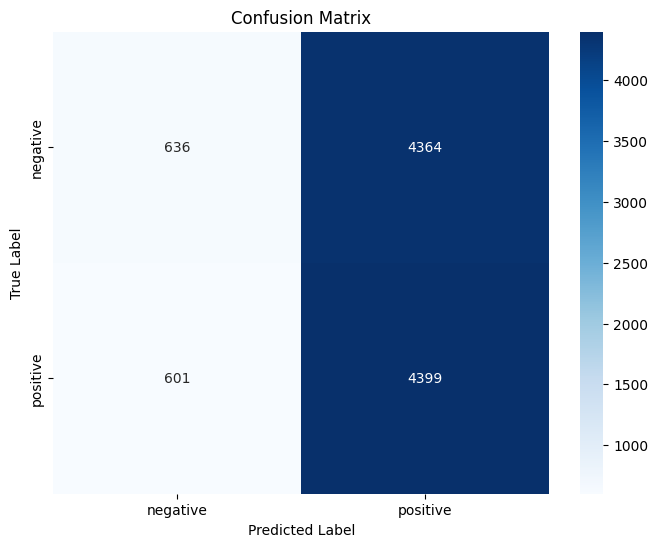

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on test data
y_pred = model_lstm_attention.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

# Convert predicted probabilities to class labels (0 or 1)
# If your model outputs probabilities directly, you can skip this step
# y_pred_classes = np.argmax(y_pred, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


Accuracy: 0.5035
Precision: 0.5019970329795732
Recall: 0.8798
F1 Score: 0.639250163481799


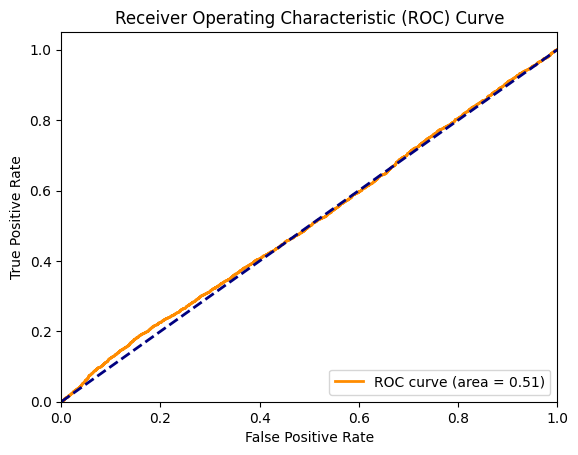

In [95]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


# Use transformers


In [ ]:
!pip install transformers

In [62]:
!pip install tf-keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.2 MB/s eta 0:00:0000:0100:01


In [63]:
from transformers import TFBertForSequenceClassification, BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model_transformer = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')



/Users/camille/miniconda3/envs/keras-jax/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
